# EDA of Bixi_bike data

In [193]:
# Imports

import pandas as pd
import numpy as np
import dask 
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import folium 
import graphviz, toolz, cloudpickle
import matplotlib
from matplotlib import rcParams
import xgboost as xgb
import pandas_profiling

import warnings

In [2]:
import os
os.chdir("../")

## Initial set up

In [5]:
matplotlib.use('nbagg') # To make the charts more interactive

## 1. EDA 

Goal of this section is to combine and merge the data into a cohesive file 

###  1.1 Merging the stations data

In [19]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is F010-882B

 Directory of C:\Users\Santhosh Suresh\Documents\GitHub\bixi-bik\data

04/16/2021  03:12 PM    <DIR>          .
04/16/2021  03:12 PM    <DIR>          ..
05/05/2017  05:55 PM    <DIR>          2014
05/05/2017  05:56 PM    <DIR>          2015
05/05/2017  06:06 PM    <DIR>          2016
12/04/2017  07:47 PM    <DIR>          2017
               0 File(s)              0 bytes
               6 Dir(s)  92,953,935,872 bytes free


In [10]:
#Load the individual files and mark the year 

stations_2014= pd.read_csv("./data/2014/Stations_2014.csv")
stations_2015= pd.read_csv("./data/2015/Stations_2015.csv")
stations_2016= pd.read_csv("./data/2016/Stations_2016.csv")
stations_2017= pd.read_csv("./data/2017/Stations_2017.csv")

stations_2014["Year"] = 2014
stations_2015["Year"] = 2015
stations_2016["Year"] = 2016
stations_2017["Year"] = 2017

In [15]:
stations_2015.columns

Index(['code', 'name', 'latitude', 'longitude', 'Year'], dtype='object')

In [33]:
# Revew shapes of the stations of each year 

print("2014: ", stations_2014.shape, ", 2015: ", stations_2015.shape, "2016: ", stations_2016.shape, 
     "2017: ", stations_2017.shape)

2014:  (459, 5) , 2015:  (460, 5) 2016:  (465, 5) 2017:  (546, 5)


In [32]:
# Merge all the dataframes into a station master

stations_master = pd.merge(stations_2014, stations_2015, how = "outer", on = ['code', 'name', 'latitude', 'longitude'], 
                          suffixes = ('_2014','_2015'))
stations_master = pd.merge(stations_master, stations_2016, how = "outer", on = ['code', 'name', 'latitude', 'longitude'])
stations_master = pd.merge(stations_master, stations_2017, how = "outer", on = ['code', 'name', 'latitude', 'longitude'],
                          suffixes = ('_2016', '_2017'))

In [48]:
unmatched_stations = stations_master[stations_master.isna().sum(axis=1)>0].sort_values(by=["latitude", "longitude"])
matched_stations = stations_master[stations_master.isna().sum(axis=1)==0].sort_values(by=["latitude", "longitude"])
unmatched_stations.head(30)

code                                   name   latitude  longitude  \
465  7015                    LaSalle / 4e avenue  45.430740 -73.591911   
466  6715         Natatorium (LaSalle / Rolland)  45.444408 -73.575568   
449  6715         Natatorium (LaSalle / Rolland)  45.444433 -73.575788   
467  7048                        Métro Angrignon  45.446534 -73.603541   
468  7056                     Godin / Bannantyne  45.447554 -73.577263   
469  7051                        Jogues / Allard  45.449901 -73.600251   
470  6706                     Beatty / de Verdun  45.450730 -73.572575   
343  6706                        Beatty / Verdun  45.450837 -73.572446   
471  7059                    Argyle / Bannantyne  45.453246 -73.576815   
419  6309                     5e avenue / Verdun  45.456049 -73.571877   
472  6309                  5e avenue / de Verdun  45.456049 -73.571877   
441  6707                        Drake / de Sève  45.456351 -73.582292   
473  6707      Métro Jolicoeur (Drake / de Sève)  45.456498 -73.582144   
464  6754                           Eadie/Dubois  45.457597 -73.590529   
474  6754                         Eadie / Dubois  45.457597 -73.590529   
475  7057                 2e avenue / Wellington  45.457894 -73.567528   
476  7010                   Belmore / Sherbrooke  45.459233 -73.637405   
477  6426  Métro Verdun (Willibrord / de Verdun)  45.459488 -73.572092   
436  6428     Berlioz / Boul de l'Ile des Soeurs  45.459593 -73.544377   
331  6426                    Willibrord / Verdun  45.459707 -73.571438   
478  6428          Berlioz / de l'Île des Soeurs  45.459986 -73.543956   
479  7058                    Gordon / Wellington  45.461078 -73.567307   
453  6742                        Briand / Carron  45.462362 -73.596650   
480  6742                      Briand / le Caron  45.462362 -73.596650   
481  7060                de l'Église / de Verdun  45.463001 -73.571569   
482  6379               de l'Église / Bannantyne  45.463254 -73.575879   
332  6379               Bannantyne / de l'Église  45.463257 -73.575621   
483  7013                 Benny Crescent / Benny  45.464315 -73.625570   
484  6115                    Benny / de Monkland  45.466914 -73.631704   
335  6115                       Benny / Monkland  45.466965 -73.631664   

     Year_2014  Year_2015  Year_2016  Year_2017  
465        NaN        NaN        NaN     2017.0  
466        NaN        NaN        NaN     2017.0  
449     2014.0     2015.0     2016.0        NaN  
467        NaN        NaN        NaN     2017.0  
468        NaN        NaN        NaN     2017.0  
469        NaN        NaN        NaN     2017.0  
470        NaN        NaN        NaN     2017.0  
343     2014.0     2015.0     2016.0        NaN  
471        NaN        NaN        NaN     2017.0  
419     2014.0     2015.0     2016.0        NaN  
472        NaN        NaN        NaN     2017.0  
441     2014.0     2015.0     2016.0        NaN  
473        NaN        NaN        NaN     2017.0  
464        NaN        NaN     2016.0        NaN  
474        NaN        NaN        NaN     2017.0  
475        NaN        NaN        NaN     2017.0  
476        NaN        NaN        NaN     2017.0  
477        NaN        NaN        NaN     2017.0  
436     2014.0     2015.0     2016.0        NaN  
331     2014.0     2015.0     2016.0        NaN  
478        NaN        NaN        NaN     2017.0  
479        NaN        NaN        NaN     2017.0  
453     2014.0     2015.0     2016.0        NaN  
480        NaN        NaN        NaN     2017.0  
481        NaN        NaN        NaN     2017.0  
482        NaN        NaN        NaN     2017.0  
332     2014.0     2015.0     2016.0        NaN  
483        NaN        NaN        NaN     2017.0  
484        NaN        NaN        NaN     2017.0  
335     2014.0     2015.0     2016.0        NaN

In [52]:
print( stations_master.shape)
print( unmatched_stations.shape)
print( matched_stations.shape)

(775, 8)
(540, 8)
(235, 8)


In [42]:
# no. of same stations with different name or code:
unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = False).sum()

94

In [41]:
unmatched_stations[unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = False)]

code                                       name   latitude  longitude  \
419  6309                         5e avenue / Verdun  45.456049 -73.571877   
472  6309                      5e avenue / de Verdun  45.456049 -73.571877   
464  6754                               Eadie/Dubois  45.457597 -73.590529   
474  6754                             Eadie / Dubois  45.457597 -73.590529   
453  6742                            Briand / Carron  45.462362 -73.596650   
..    ...                                        ...        ...        ...   
746  6737        Jacques-Casault / Christophe-Colomb  45.552123 -73.630103   
418  6701                           Marseille / Viau  45.563921 -73.548912   
766  6701                        de Marseille / Viau  45.563921 -73.548912   
289  6721                      Cadillac / Sherbrooke  45.577136 -73.546289   
772  6721  Métro Cadillac (Sherbrooke / de Cadillac)  45.577136 -73.546289   

     Year_2014  Year_2015  Year_2016  Year_2017  
419     2014.0     2015.0     2016.0        NaN  
472        NaN        NaN        NaN     2017.0  
464        NaN        NaN     2016.0        NaN  
474        NaN        NaN        NaN     2017.0  
453     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...  
746        NaN        NaN        NaN     2017.0  
418     2014.0     2015.0     2016.0        NaN  
766        NaN        NaN        NaN     2017.0  
289     2014.0     2015.0     2016.0        NaN  
772        NaN        NaN        NaN     2017.0  

[94 rows x 8 columns]

The above 47 stations simply have different names, and represent the exact same
location (from a lat-long perspective). So we will drop the older versions and keep the new versions

In [53]:
unique_unmatched_stations = unmatched_stations[~(unmatched_stations.duplicated(subset=['latitude', 'longitude'], keep = "last"))] 
unique_unmatched_stations.sort_values(by='code')

code                                 name   latitude  longitude  \
284  5002             St-Charles / Châteauguay  45.533200 -73.515600   
663  5002             St-Charles / Montarville  45.533703 -73.515283   
647  5003                      Place Longueuil  45.529512 -73.517691   
357  5003                      Place Longueuil  45.529400 -73.517800   
322  5005            St-Charles / St-Sylvestre  45.536408 -73.512776   
..    ...                                  ...        ...        ...   
628  7077               Fullum / Jean Langlois  45.526128 -73.546002   
667  7078                 Hochelaga / Chapleau  45.534453 -73.559652   
533  7079                  Gauvin / Notre-Dame  45.500043 -73.560412   
546  7080  President-Kennedy / Robert Bourassa  45.504407 -73.572543   
515  7081             Lincoln / Lambert Closse  45.491384 -73.586013   

     Year_2014  Year_2015  Year_2016  Year_2017  
284     2014.0     2015.0     2016.0        NaN  
663        NaN        NaN        NaN     2017.0  
647        NaN        NaN        NaN     2017.0  
357     2014.0     2015.0     2016.0        NaN  
322     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...  
628        NaN        NaN        NaN     2017.0  
667        NaN        NaN        NaN     2017.0  
533        NaN        NaN        NaN     2017.0  
546        NaN        NaN        NaN     2017.0  
515        NaN        NaN        NaN     2017.0  

[493 rows x 8 columns]

In [57]:
# Even though the code is the same, the location and/ or name have changed in 2017 in some cases. 

#HOw many of the 493 have the same code? 

unique_unmatched_stations[unique_unmatched_stations.duplicated(subset=["code"], keep=False)].sort_values(by='code')

code                           name   latitude  longitude  Year_2014  \
284  5002       St-Charles / Châteauguay  45.533200 -73.515600     2014.0   
663  5002       St-Charles / Montarville  45.533703 -73.515283        NaN   
357  5003                Place Longueuil  45.529400 -73.517800     2014.0   
647  5003                Place Longueuil  45.529512 -73.517691        NaN   
322  5005      St-Charles / St-Sylvestre  45.536408 -73.512776     2014.0   
..    ...                            ...        ...        ...        ...   
749  6925      Louis-Hébert / Jean-Talon  45.553139 -73.602711        NaN   
416  6929         St-André / St-Grégoire  45.531330 -73.591550     2014.0   
653  6929         St-André / St-Grégoire  45.531412 -73.591749        NaN   
461  6930            Paul Boutet / Jarry  45.559178 -73.614130        NaN   
763  6930  Paul Boutet / des Regrattiers  45.559842 -73.615447        NaN   

     Year_2015  Year_2016  Year_2017  
284     2015.0     2016.0        NaN  
663        NaN        NaN     2017.0  
357     2015.0     2016.0        NaN  
647        NaN        NaN     2017.0  
322     2015.0     2016.0        NaN  
..         ...        ...        ...  
749        NaN        NaN     2017.0  
416     2015.0     2016.0        NaN  
653        NaN        NaN     2017.0  
461        NaN     2016.0        NaN  
763        NaN        NaN     2017.0  

[364 rows x 8 columns]

In [77]:
# For the sake of simplicity, in these 182 stations, we will assume the 2017 name and lat-long, 
# we are assuming (perhaps, safely) that the lat-long difference is quite small 

unmatched_stations_codes = unique_unmatched_stations[~unique_unmatched_stations.sort_values(by='code')\
                                                     .duplicated(subset=['code'], keep = 'last')]

unmatched_stations_codes.sort_values(by='code')

<ipython-input-77-1e054f537fa0>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  unmatched_stations_codes = unique_unmatched_stations[~unique_unmatched_stations.sort_values(by='code')\


code                                            name   latitude  \
663  5002                        St-Charles / Montarville  45.533703   
357  5003                                 Place Longueuil  45.529400   
678  5005                       St-Charles / St-Sylvestre  45.536378   
559  6001  Hôtel-de-Ville 2 (du Champs-de-Mars / Gosford)  45.509328   
253  6002                          Ste-Catherine / Dézéry  45.539230   
..    ...                                             ...        ...   
628  7077                          Fullum / Jean Langlois  45.526128   
667  7078                            Hochelaga / Chapleau  45.534453   
533  7079                             Gauvin / Notre-Dame  45.500043   
546  7080             President-Kennedy / Robert Bourassa  45.504407   
515  7081                        Lincoln / Lambert Closse  45.491384   

     longitude  Year_2014  Year_2015  Year_2016  Year_2017  
663 -73.515283        NaN        NaN        NaN     2017.0  
357 -73.517800     2014.0     2015.0     2016.0        NaN  
678 -73.512642        NaN        NaN        NaN     2017.0  
559 -73.554347        NaN        NaN        NaN     2017.0  
253 -73.541082     2014.0     2015.0     2016.0        NaN  
..         ...        ...        ...        ...        ...  
628 -73.546002        NaN        NaN        NaN     2017.0  
667 -73.559652        NaN        NaN        NaN     2017.0  
533 -73.560412        NaN        NaN        NaN     2017.0  
546 -73.572543        NaN        NaN        NaN     2017.0  
515 -73.586013        NaN        NaN        NaN     2017.0  

[311 rows x 8 columns]

In [78]:
# They all look like new additions from 2017? 
unmatched_stations_codes.isna().sum()

code           0
name           0
latitude       0
longitude      0
Year_2014    217
Year_2015    216
Year_2016    214
Year_2017     96
dtype: int64

In [79]:
#Some 96 stations were only present during 2014- 2016. Versus ~217 stations were pretty much created in 2017. 

unmatched_stations_codes[unmatched_stations_codes["Year_2017"].isna()]
#We try to look for any special information regarding the locations that were disabled in 2017

code                             name   latitude  longitude  Year_2014  \
343  6706                  Beatty / Verdun  45.450837 -73.572446     2014.0   
441  6707                  Drake / de Sève  45.456351 -73.582292     2014.0   
331  6426              Willibrord / Verdun  45.459707 -73.571438     2014.0   
335  6115                 Benny / Monkland  45.466965 -73.631664     2014.0   
338  6363          Côte St-Antoine / Royal  45.468800 -73.619800     2014.0   
..    ...                              ...        ...        ...        ...   
307  6033            16e avenue / Beaubien  45.558481 -73.583304     2014.0   
66   6395       Pierre-de-Coubertin / Aird  45.558960 -73.548687     2014.0   
270  6735  François-Perrault / L.-O.-David  45.561396 -73.601544     2014.0   
463  6753          St-Zotique / 39e avenue  45.573471 -73.574975        NaN   
423  6722    Bossuet / Pierre-de-Coubertin  45.573733 -73.539446     2014.0   

     Year_2015  Year_2016  Year_2017  
343     2015.0     2016.0        NaN  
441     2015.0     2016.0        NaN  
331     2015.0     2016.0        NaN  
335     2015.0     2016.0        NaN  
338     2015.0     2016.0        NaN  
..         ...        ...        ...  
307     2015.0     2016.0        NaN  
66      2015.0     2016.0        NaN  
270     2015.0     2016.0        NaN  
463        NaN     2016.0        NaN  
423     2015.0     2016.0        NaN  

[96 rows x 8 columns]

#### Check the two stations for which our prediction is most concerned

In [68]:
unmatched_stations_codes[unmatched_stations_codes['code'].isin([6184,6015])]

Empty DataFrame
Columns: [code, name, latitude, longitude, Year_2014, Year_2015, Year_2016, Year_2017]
Index: []

In [133]:
prio_points= matched_stations[matched_stations['code'].isin([6184,6015])]
prio_points

code                                       name   latitude  longitude  \
105  6015                     Berri / de Maisonneuve  45.515299 -73.561273   
55   6184  Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673 -73.582550   

     Year_2014  Year_2015  Year_2016  Year_2017  
105     2014.0     2015.0     2016.0     2017.0  
55      2014.0     2015.0     2016.0     2017.0

In [71]:
unmatched_stations_codes.columns

Index(['code', 'name', 'latitude', 'longitude', 'Year_2014', 'Year_2015',
       'Year_2016', 'Year_2017'],
      dtype='object')

In [113]:
# The two main locations have been consistent through the years. 

#2014-2016 change in stations has been minimal and can be ignored for the purposes of this exercise. 
# the 2017 piece cannot be ignored as it is somewhat significant. It is illustrative to understand the extent 
# of these changes in a graphical way. 

def categorizer(s):
    if s.iloc[0:3].isna().sum()==3:
        return 0 #2017 only 
    elif np.isnan(s.iloc[3]) and s.iloc[0:3].isna().sum()==0:
        return 0.5 #decommissioned in 2017
    else:
        return 1  #Other

unmatched_stations_codes["category"] = (unmatched_stations_codes[['Year_2014', 'Year_2015',
       'Year_2016','Year_2017']].apply(categorizer,axis = 1))

<ipython-input-113-f94437f86588>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmatched_stations_codes["category"] = (unmatched_stations_codes[['Year_2014', 'Year_2015',


In [114]:
unmatched_stations_codes.category.value_counts()

0.0    214
0.5     94
1.0      3
Name: category, dtype: int64

In [101]:
unmatched_stations_codes.shape

(311, 9)

In [115]:
unmatched_stations_codes[unmatched_stations_codes.category==1]

code                     name   latitude  longitude  Year_2014  \
462  6752     Hutchison / Beaubien  45.526246 -73.613747        NaN   
460  6311      Drolet / St-Zotique  45.534795 -73.609546        NaN   
463  6753  St-Zotique / 39e avenue  45.573471 -73.574975        NaN   

     Year_2015  Year_2016  Year_2017  category  
462        NaN     2016.0     2017.0       1.0  
460     2015.0     2016.0        NaN       1.0  
463        NaN     2016.0        NaN       1.0

<IPython.core.display.Javascript object>


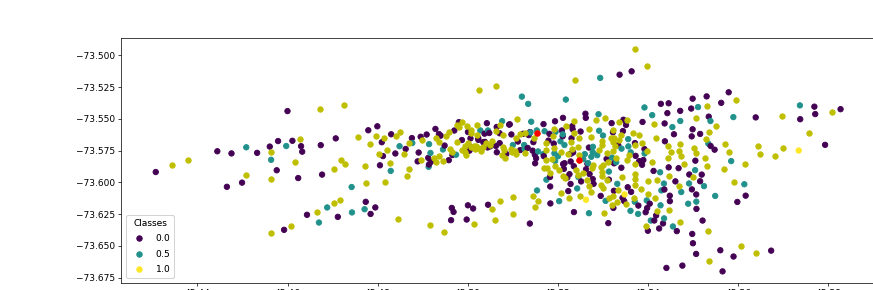

In [194]:
plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

scatter = ax.scatter(unmatched_stations_codes["latitude"], unmatched_stations_codes['longitude'], 
           c= unmatched_stations_codes['category'])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
#purple dots representing the newly added stations in 2017
#blue dots representing removed stations


ax.scatter(matched_stations['latitude'], matched_stations['longitude'], c='y')
#gray dots representing the unchanged stations 

ax.scatter(prio_points['latitude'], prio_points['longitude'], c='r') 
#red dots representing the concerned origin and destination

ax.add_artist(legend1)

In [207]:
## Unfortunately, the red-dots seem to be have been surrounded by some stations that were clearly replaced in
# 2017 by other stations that were further away from the red-dot

#Hence, we should consider the adjusted demand when making our prediction

stations_df = pd.concat([unmatched_stations_codes, matched_stations])

In [210]:
stations_df.loc[stations_df.category.isna(),"category"] = "Fully Matched"

In [212]:
stations_df.category.value_counts()

#stations_df is the one source of truth on DataFrames

Fully Matched    235
0.0              214
0.5               94
1.0                3
Name: category, dtype: int64

### 1.2 Rides data ETL

In [166]:
folders = range(2014,2018)
active_months = range(4,12)

df_dict = dict()

for year in folders:
    for month in active_months: 
        if year == 2017 and month==9:
            break
        df = pd.read_csv(f"./data/{year}/OD_{year}-{month:02}.csv")
        print(year, month,": ", df.shape)
        df_dict[str(year)+'-'+f"{month:02}"] = df

2014 4 :  (108264, 6)
2014 5 :  (455261, 6)
2014 6 :  (525863, 6)
2014 7 :  (569352, 6)
2014 8 :  (556780, 6)
2014 9 :  (477545, 6)
2014 10 :  (331818, 6)
2014 11 :  (111393, 6)
2015 4 :  (150271, 6)
2015 5 :  (545678, 6)
2015 6 :  (547238, 6)
2015 7 :  (620865, 6)
2015 8 :  (597505, 6)
2015 9 :  (523322, 6)
2015 10 :  (332597, 6)
2015 11 :  (126407, 6)
2016 4 :  (194514, 6)
2016 5 :  (573739, 6)
2016 6 :  (645448, 6)
2016 7 :  (716335, 6)
2016 8 :  (688174, 6)
2016 9 :  (632218, 6)
2016 10 :  (397707, 6)
2016 11 :  (151945, 6)
2017 4 :  (196327, 6)
2017 5 :  (589852, 6)
2017 6 :  (748078, 6)
2017 7 :  (877338, 6)
2017 8 :  (859471, 6)


In [167]:
df_dict.keys()

dict_keys(['2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08'])

In [163]:
#Looking at a sample dataframe
df_dict['2014-04'].columns

Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')

In [164]:
df_dict['2014-04'].dtypes

start_date            object
start_station_code     int64
end_date              object
end_station_code       int64
duration_sec           int64
is_member              int64
dtype: object

In [165]:
df_dict['2014-04'].head()

start_date  start_station_code          end_date  end_station_code  \
0  2014-04-15 00:01                6209  2014-04-15 00:18              6436   
1  2014-04-15 00:01                6214  2014-04-15 00:11              6248   
2  2014-04-15 00:01                6164  2014-04-15 00:18              6216   
3  2014-04-15 00:01                6214  2014-04-15 00:24              6082   
4  2014-04-15 00:02                6149  2014-04-15 00:08              6265   

   duration_sec  is_member  
0          1061          1  
1           615          1  
2          1031          1  
3          1382          1  
4           347          1

In [172]:
full_data = df = pd.concat(df_dict)

In [173]:
df.shape

(13851305, 6)

In [174]:
#Check for nulls

df.isna().sum()

start_date            0
start_station_code    0
end_date              0
end_station_code      0
duration_sec          0
is_member             0
dtype: int64

In [175]:
#Yay! No nulls. 

#Convert start_date and end_date to date time

df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)


In [181]:
df.columns

Index(['start_date', 'start_station_code', 'end_date', 'end_station_code',
       'duration_sec', 'is_member'],
      dtype='object')

In [187]:
df.describe()

start_station_code  end_station_code  duration_sec     is_member
count        1.385130e+07      1.385130e+07  1.385130e+07  1.385130e+07
mean         6.267494e+03      6.261352e+03  8.256380e+02  8.287203e-01
std          3.125649e+02      3.206701e+02  6.587065e+02  3.767532e-01
min          5.002000e+03      5.002000e+03  6.100000e+01  0.000000e+00
25%          6.100000e+03      6.085000e+03  3.740000e+02  1.000000e+00
50%          6.192000e+03      6.184000e+03  6.560000e+02  1.000000e+00
75%          6.322000e+03      6.332000e+03  1.100000e+03  1.000000e+00
max          1.000200e+04      1.000200e+04  7.199000e+03  1.000000e+00

In [190]:
df.is_member = df.is_member.astype('bool')

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13851305 entries, ('2014-04', 0) to ('2017-08', 859470)
Data columns (total 6 columns):
 #   Column              Dtype         
---  ------              -----         
 0   start_date          datetime64[ns]
 1   start_station_code  int64         
 2   end_date            datetime64[ns]
 3   end_station_code    int64         
 4   duration_sec        int64         
 5   is_member           bool          
dtypes: bool(1), datetime64[ns](2), int64(3)
memory usage: 646.6+ MB


In [195]:
df.boxplot()

plt.show()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


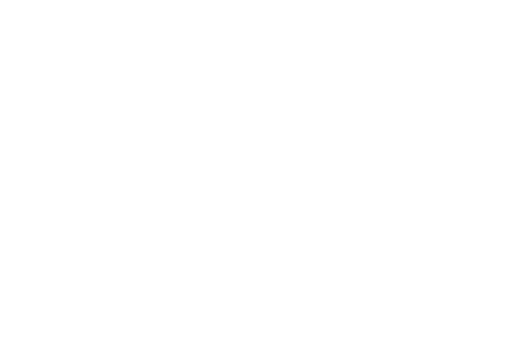

<IPython.core.display.Javascript object>


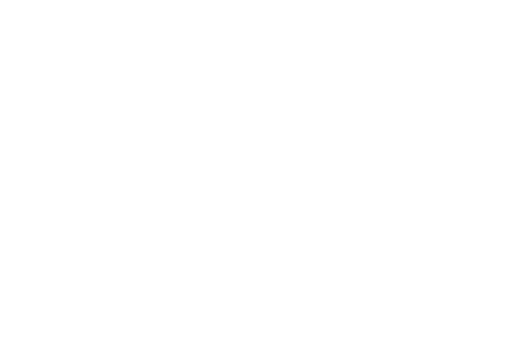

<IPython.core.display.Javascript object>


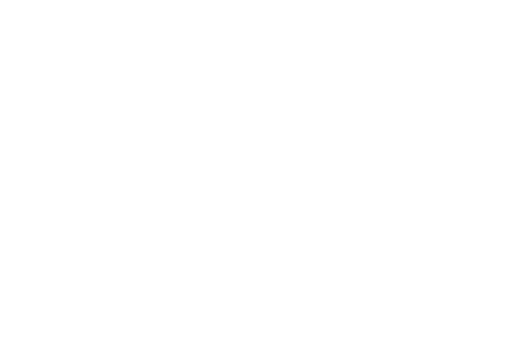

<IPython.core.display.Javascript object>


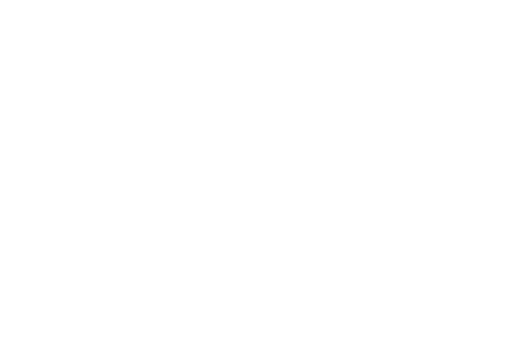

<IPython.core.display.Javascript object>


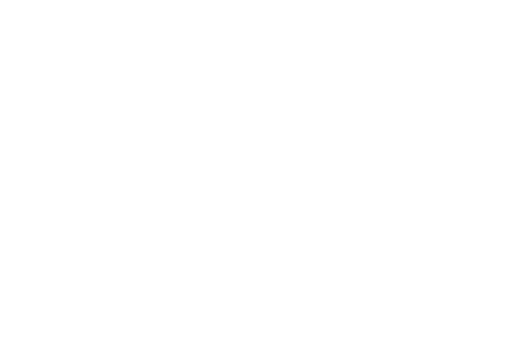

<IPython.core.display.Javascript object>


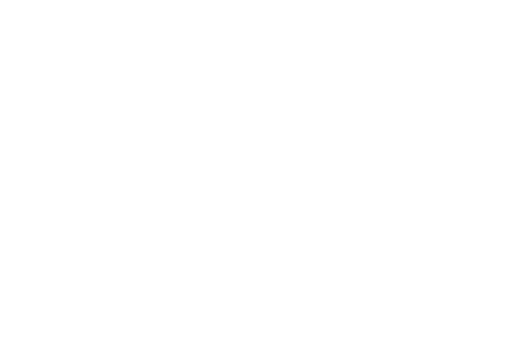

<IPython.core.display.Javascript object>


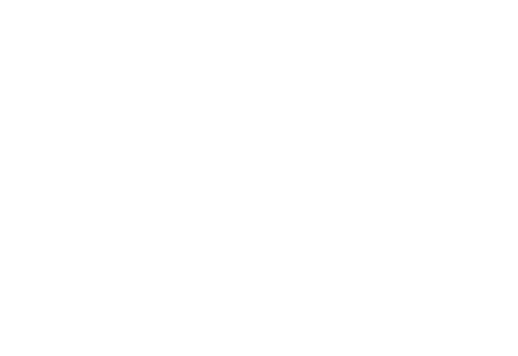

<IPython.core.display.Javascript object>


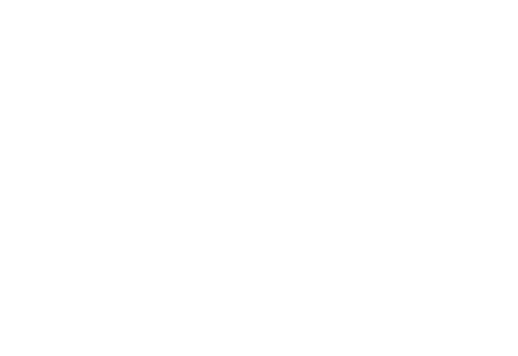

<IPython.core.display.Javascript object>


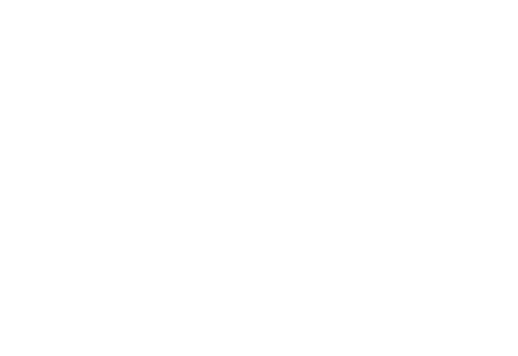

<IPython.core.display.Javascript object>


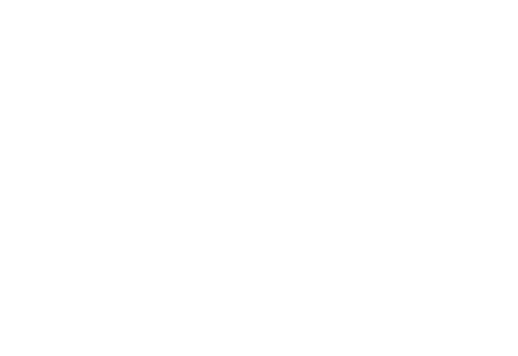

<IPython.core.display.Javascript object>


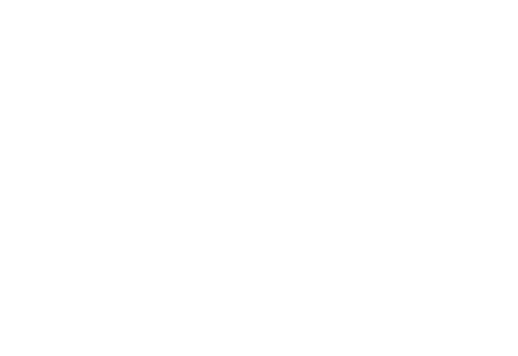

<IPython.core.display.Javascript object>


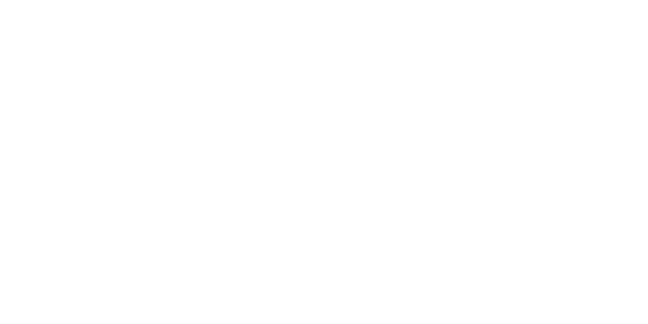

<IPython.core.display.Javascript object>


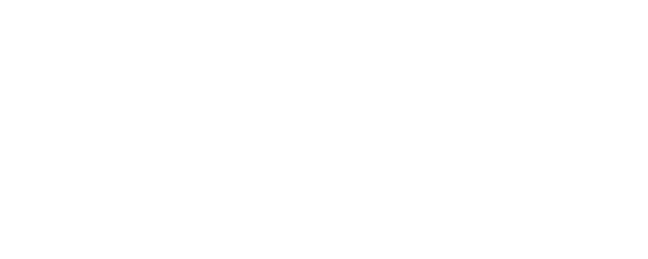

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


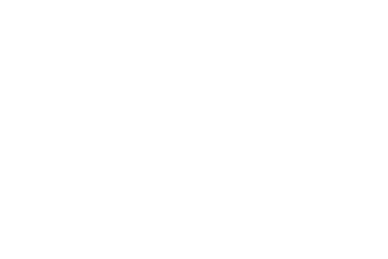

<IPython.core.display.Javascript object>


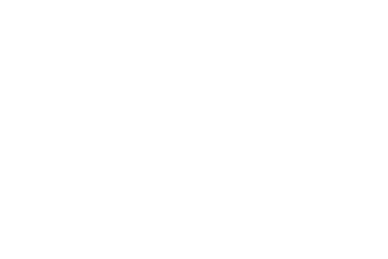

<IPython.core.display.Javascript object>


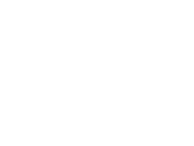

<IPython.core.display.Javascript object>


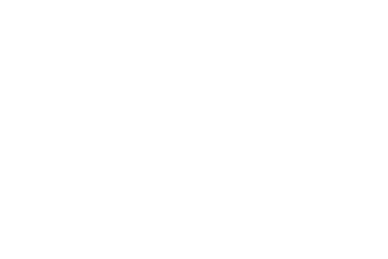

<IPython.core.display.Javascript object>


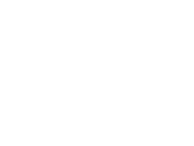

<IPython.core.display.Javascript object>


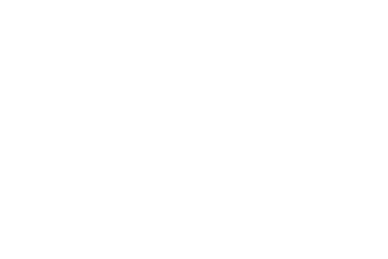

<IPython.core.display.Javascript object>


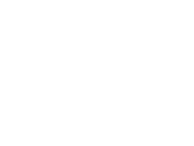

<IPython.core.display.Javascript object>


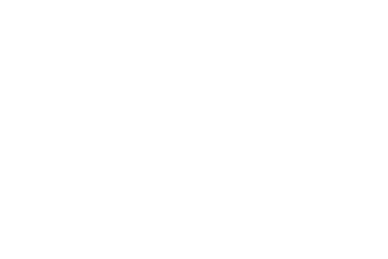

<IPython.core.display.Javascript object>


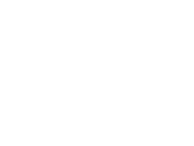

<IPython.core.display.Javascript object>


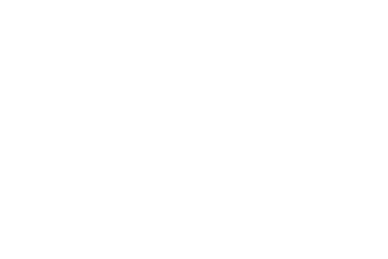

<IPython.core.display.Javascript object>


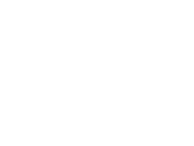

<IPython.core.display.Javascript object>


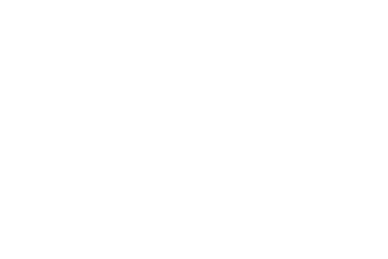

<IPython.core.display.Javascript object>


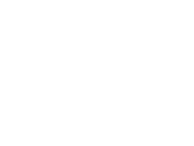

<IPython.core.display.Javascript object>


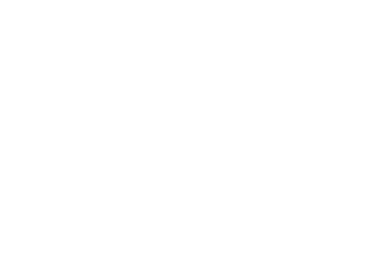

<IPython.core.display.Javascript object>


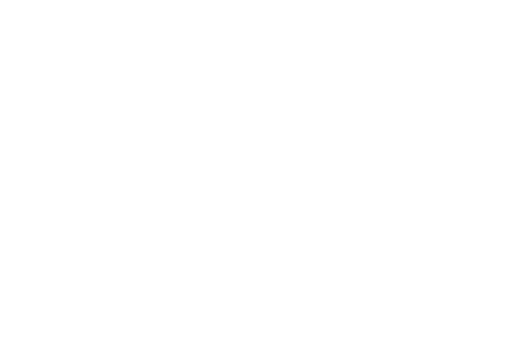

<IPython.core.display.Javascript object>


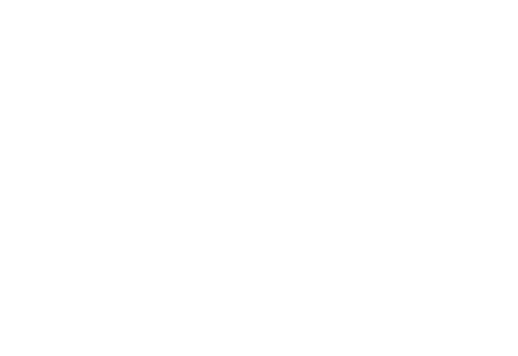

<IPython.core.display.Javascript object>


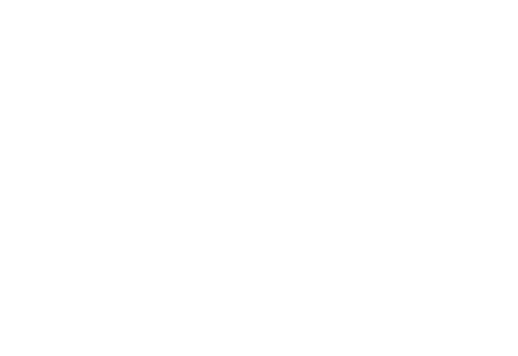

<IPython.core.display.Javascript object>


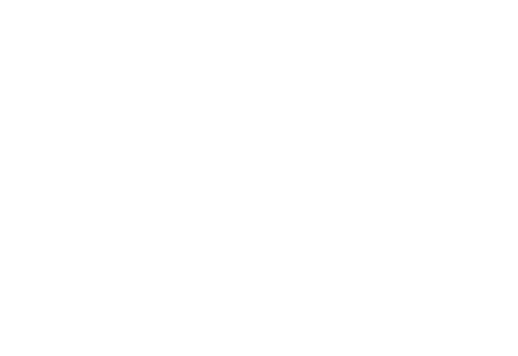

<IPython.core.display.Javascript object>


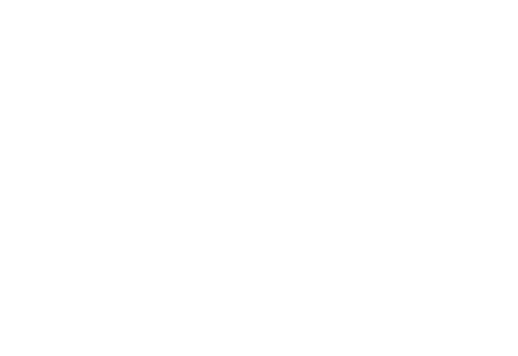

<IPython.core.display.Javascript object>


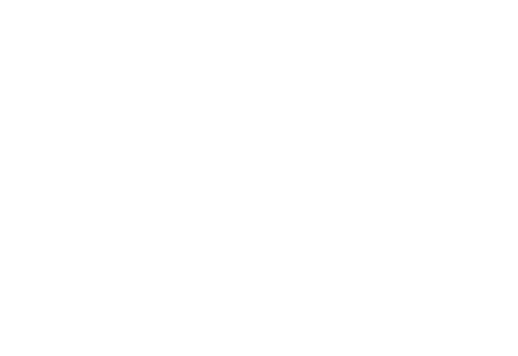

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [196]:
df.profile_report()

#### Some observations:
* Not too many surprises, but interestingly:
    * No nulls or nans - clean data in that sense 
    * There is a clear up-tick in the number of users over the years, that's almost growing exponentially
    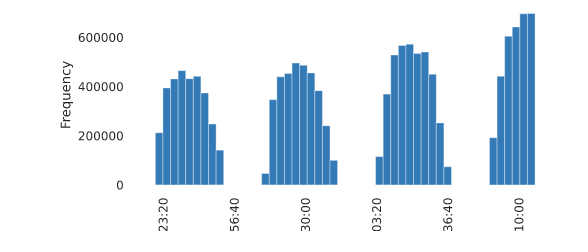
    
    * Some correlation between start and end points- presumably a lot of same location drop-offs:
    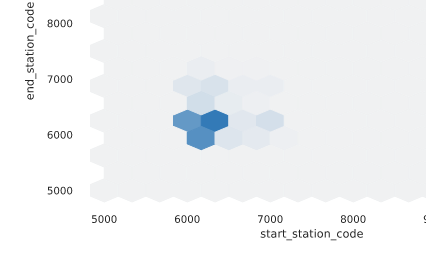
    * Some negative correlation between being a mamber and duration; Means non-members only rent the bike for longer rides:
    
    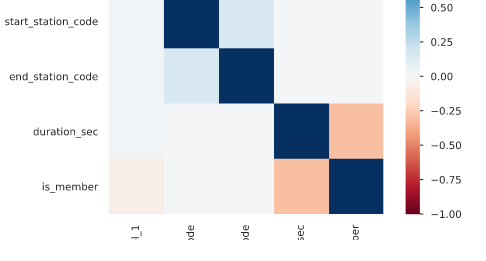
    
   
 * As expected, a log normal(or exponential?) distribution of the duration:
 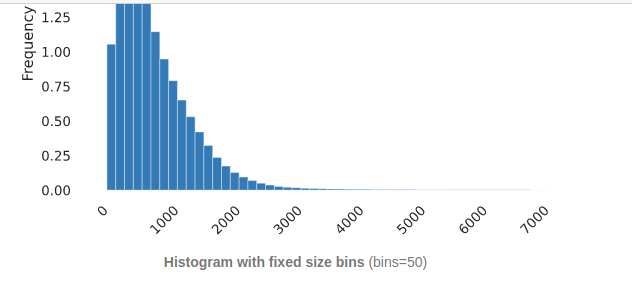
    
    

## 2. Initial visualizations 

## 3. Data Cleaning 

## 4. Feature Engineering 